# Calculate the ensamble distributions

## Import libraries

In [2]:
from src.preproces import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xclim import ensembles
from pathlib import Path

## Open an ensamble and calculate the distribution for the whole time series

For ensambles we will use the xclim package which provides easy handling of xarray datasets for ensamble work and calulations. In this package each ensamble member is called a realization. Since some pathways in our data is only simulated until 2100 I will cut every pathway at this point as well. 

In [5]:
# Define the path to the data folder
data_dir = Path('/nird/home/johannef/FYS-STK4155_Project_3 DataFiles/tas/ssp126')
# Create the ensemble and load it into memory
ens = ensembles.create_ensemble(data_dir.glob("*.nc"))

ens = ens.sel(year=slice(None,'2100'))
# Print the ensemble
print(ens)

<xarray.Dataset>
Dimensions:      (year: 86, realization: 40)
Coordinates:
  * year         (year) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
    height       float64 2.0
  * realization  (realization) int64 0 1 2 3 4 5 6 7 ... 32 33 34 35 36 37 38 39
Data variables:
    tas          (realization, year) float32 dask.array<chunksize=(1, 86), meta=np.ndarray>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


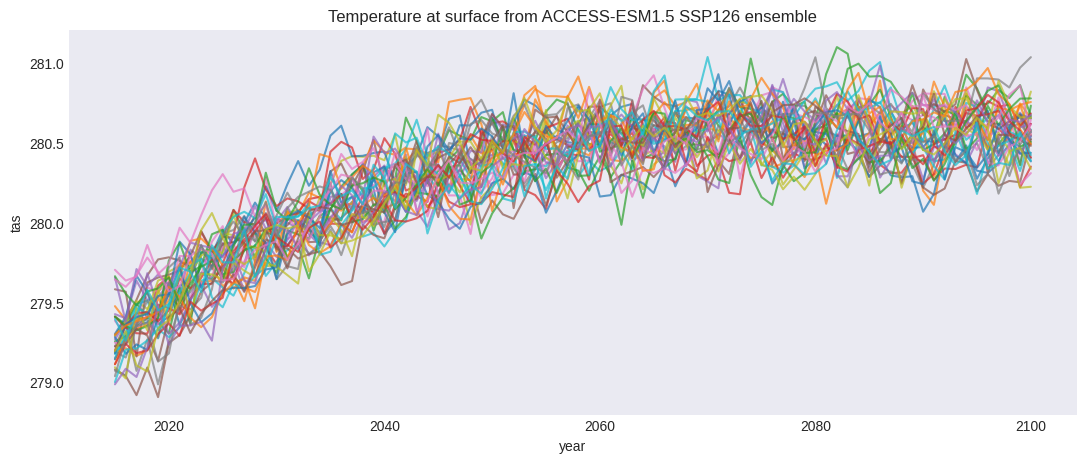

In [8]:
plt.style.use("seaborn-v0_8-dark")
plt.rcParams["figure.figsize"] = (13, 5)
ens.tas.plot(hue="realization", alpha=0.7)
plt.legend(ncol=3)
plt.title("Temperature at surface from ACCESS-ESM1.5 SSP126 ensemble")
plt.show()

We observe here the noisy nature of the different realizations.

Now we can calculate the ensamble statistics

In [4]:
ens_stats = ensembles.ensemble_mean_std_max_min(ens)
ens_stats

<xarray.Dataset>
Dimensions:   (year: 86)
Coordinates:
  * year      (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
Data variables:
    pr_mean   (year) float32 dask.array<chunksize=(86,), meta=np.ndarray>
    pr_stdev  (year) float32 dask.array<chunksize=(86,), meta=np.ndarray>
    pr_max    (year) float32 dask.array<chunksize=(86,), meta=np.ndarray>
    pr_min    (year) float32 dask.array<chunksize=(86,), meta=np.ndarray>
Attributes:
    history:  [2023-12-02 13:22:57] : Computation of statistics on 40 ensembl...

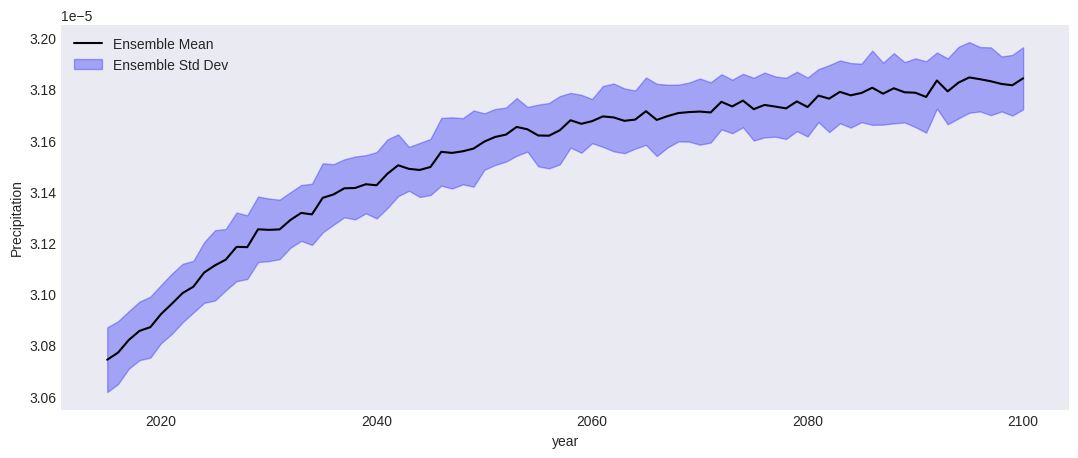

In [5]:
plt.plot(ens_stats.year, ens_stats.pr_mean, color='black', label='Ensemble Mean')
plt.fill_between(ens_stats.year, ens_stats.pr_mean - ens_stats.pr_stdev, ens_stats.pr_mean + ens_stats.pr_stdev, 
                 color='blue', alpha=0.3, label='Ensemble Std Dev')
plt.xlabel('year')
plt.ylabel('Precipitation')
plt.legend()
plt.show()


## Calculate for all ssp scenarios and plot

In [6]:
file_handler = Handle_Files()
data_dir_pr = '/nird/home/johannef/FYS-STK4155_Project_3 DataFiles/pr'
data_dir_tas = '/nird/home/johannef/FYS-STK4155_Project_3 DataFiles/tas'

ensambles_pr = {}
ensambles_tas = {}
ensambles_pr_stats = {}
ensambles_tas_stats = {}
for scenario in file_handler.get_all_filenames_in_dir(data_dir_pr):
    
    pr_ens = ensembles.create_ensemble(Path(data_dir_pr + '/' + scenario).glob("*.nc")).sel(year=slice(None,'2100'))
    pr_ens_stats = ensembles.ensemble_mean_std_max_min(pr_ens)

    tas_ens = ensembles.create_ensemble(Path(data_dir_tas + '/' + scenario).glob("*.nc")).sel(year=slice(None,'2100'))
    tas_ens_stats = ensembles.ensemble_mean_std_max_min(tas_ens)    

    ensambles_pr[scenario] = pr_ens
    ensambles_tas[scenario] = tas_ens
    ensambles_pr_stats[scenario] = pr_ens_stats
    ensambles_tas_stats[scenario] = tas_ens_stats

Plot the ensamble stats

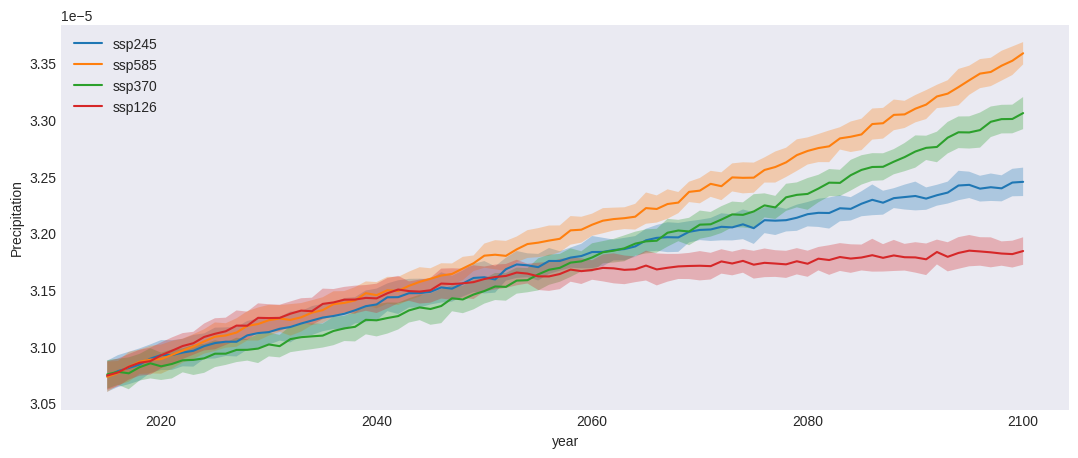

In [7]:
fig, ax = plt.subplots(1, 1)

for scenario_name, ens in ensambles_pr_stats.items():
    ax.plot(ens.year, ens.pr_mean, label=scenario_name)
    ax.fill_between(ens.year, ens.pr_mean - ens.pr_stdev, ens.pr_mean + ens.pr_stdev, alpha=0.3)

plt.xlabel('year')
plt.ylabel('Precipitation')
plt.legend()
plt.show()

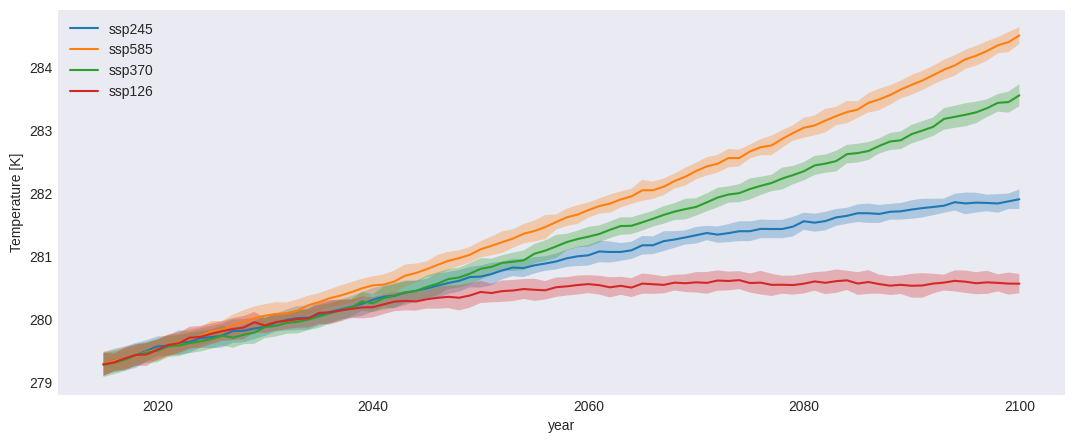

In [12]:
fig, ax = plt.subplots(1, 1)

for scenario_name, ens in ensambles_tas_stats.items():
    ax.plot(ens.year, ens.tas_mean, label=scenario_name)
    ax.fill_between(ens.year, ens.tas_mean - ens.tas_stdev, ens.tas_mean + ens.tas_stdev, alpha=0.3)

plt.xlabel('year')
plt.ylabel('Temperature [K]')
plt.legend()
plt.show()

Let us save the datasets for later usage.

In [11]:
for var_name, ens_dict in zip(['pr', 'tas'], [ensambles_pr, ensambles_tas]):
    for scenario_name, ens in ensambles_pr.items():
        file_handler.save_dataset_to_netcdf(ens, 
                                            file_name=('ensamble_for_' + var_name + '_day_ACCESS-ESM1-5_' + scenario_name + 
                                                       '20150101-21001231_global_yearly_climatology.nc'), 
                                            directory='/nird/home/johannef/FYS-STK4155_Project_3 DataFiles/'+var_name+'/ensembles')

for var_name, ens_dict in zip(['pr', 'tas'], [ensambles_pr_stats, ensambles_tas_stats]):
    for scenario_name, ens in ensambles_pr_stats.items():
        file_handler.save_dataset_to_netcdf(ens, 
                                            file_name=('ensamble_stats_for_' + var_name + '_day_ACCESS-ESM1-5_' + scenario_name + 
                                                       '20150101-21001231_global_yearly_climatology.nc'), 
                                            directory='/nird/home/johannef/FYS-STK4155_Project_3 DataFiles/'+var_name+'/ensemble_stats')
